# Predicting Education Level

## Introduction

At some point in our lives we must decide on how to make a living. People wish to find a path that leads to the most success without using too many resources, and one of the main problems to that is education. The decision to pursue a higher education is both time and money-consuming, which is why our Data Science project question is: "Can we predict the highest level of education someone has received based on their salary, years of experience, and age?"

The dataset we are using contains 7 columns reading left to right: `Education`, `Experience`, `Location`, `Job_Title`, `Age`, `Gender`, `Salary`, where each row represents an individual worker.

- `Education`: four categories representing the highest level of education received: High School, Bachelor, Master, PhD
- `Experience`: years of professional experience
- `Location`: three locations of work: Urban, Suburban, Rural
- `Job_Title`: four general job titles: Manager, Director, Analyst, Engineer
- `Age`: age
- `Gender`: Female or Male
- `Salary`: annual salary

## Data analysis

In order to do the data analysis, we first need to download and load in our data.

In [204]:
# Load in the library needed to read the csv file
library(tidyverse)

In [205]:
# Download and load the csv file into a data frame
# Dataset website: https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
# Dataset file website: https://raw.githubusercontent.com/WhenLifeHandsYouLemons/UBC-DSCI-100-Project/main/data/salary_prediction_data.csv
download.file("https://raw.githubusercontent.com/WhenLifeHandsYouLemons/UBC-DSCI-100-Project/main/data/salary_prediction_data.csv", "data/salary_prediction_data.csv")

df_untidy <- read_csv("data/salary_prediction_data.csv")

# Dataset before cleaning
head(df_untidy)

Rows: 1000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, Location, Job_Title, Gender
dbl (3): Experience, Age, Salary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,Experience,Location,Job_Title,Age,Gender,Salary
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
High School,8,Urban,Manager,63,Male,84620.05
PhD,11,Suburban,Director,59,Male,142591.26
Bachelor,28,Suburban,Manager,61,Female,97800.26
High School,29,Rural,Director,45,Male,96834.67
PhD,25,Urban,Analyst,26,Female,132157.79
PhD,19,Rural,Director,27,Female,156312.94


We then need to tidy our dataset to only include the columns (variables) we'll use and then clean up the row data to make sense. We clean it by making the variables all lowercase and use underlines instead of spaces. We also round the `salary` column to be $2$ decimal places.

In [206]:
# Rename all the columns to include the units and be in lowercase
# Then select the newly mutated columns that we will use in our analysis only
df_tidy <- df_untidy |>
    mutate(education = Education, experience_years = Experience, salary_dollars = Salary) |>
    select(salary_dollars, education, experience_years) |>
    mutate(salary_dollars = round(salary_dollars, 2)) |>    # We round the dollars to 2 decimal places
    mutate(education = as_factor(education))                # We change the column's data type

# Create dummy variables for education levels
# This is used for predicting and then combined into one for visualisations
df_tidy$phd <- as.numeric(df_tidy$education == "PhD")
df_tidy$bachelor <- as.numeric(df_tidy$education == "Bachelor")
df_tidy$master <- as.numeric(df_tidy$education == "Master")
df_tidy$high_school <- as.numeric(df_tidy$education == "High School")

# This is the same dataset, but cleaned up
head(df_tidy)

salary_dollars,education,experience_years,phd,bachelor,master,high_school
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
84620.05,High School,8,0,0,0,1
142591.26,PhD,11,1,0,0,0
97800.26,Bachelor,28,0,1,0,0
96834.67,High School,29,0,0,0,1
132157.79,PhD,25,1,0,0,0
156312.94,PhD,19,1,0,0,0


In order to make the regression work, we needed to change the `education` column from classes to integer variables.

In [207]:
# Load library for spliting data into training and testing
library(tidymodels)

Now, we can split our entire dataset into a training and a testing split. To make it consistent each time (not be affected by randomness), we use the `set.seed()` function to make it split the same each time it's run.

Before we do the training and analysis though, we can look at a subsection of our data and get some simple statistics from it to get an idea of how our data looks like:

In [208]:
# Set the seed for this code cell
set.seed(1)

# Split data into a rough 75-25 split
df_split <- initial_split(df_tidy, 0.75, salary_dollars)
df_train <- training(df_split)
df_testing <- testing(df_split)

# Summarise the values in each of our predictor classes
df_summary <- df_train |>
    summarise("Total observations in subsection" = length(experience_years),
              "Average experience (years)" = round(mean(experience_years, na.rm = TRUE)),
              "Average salary (dollars)" = round(mean(salary_dollars, na.rm = TRUE), 2),
              "Total high-school educations" = sum(high_school, na.rm = TRUE),
              "Total Bachelor educations" = sum(bachelor, na.rm = TRUE),
              "Total Master educations" = sum(master, na.rm = TRUE),
              "Total PhD educations" = sum(phd, na.rm = TRUE))

# The split sizes and the summary is shown below
df_split
df_summary

#! Here we need to show the plot visualisations of the data and predictors then talk about it

<Training/Testing/Total>
<748/252/1000>

Total observations in subsection,Average experience (years),Average salary (dollars),Total high-school educations,Total Bachelor educations,Total Master educations,Total PhD educations
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
748,15,105568.6,190,184,195,179


NOTE: Our data didn't seem to have any observations with missing data (or `NA`) but we still included `na.rm=TRUE` just in case.

Now that we've looked at our data and some simple statistics and visualisations of it, we can move on to creating our regression model:

In [209]:
# Train the linear regression model on all the predictors (education levels and experience) using the training data split
reg_model <- lm(salary_dollars ~ experience_years + phd + bachelor + master, data = df_train)

# Summarize the regression results
summary(reg_model)


Call:
lm(formula = salary_dollars ~ experience_years + phd + bachelor + 
    master, data = df_train)

Residuals:
   Min     1Q Median     3Q    Max 
-41100 -11379   -259  10364  36197 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      60926.43    1396.04   43.64   <2e-16 ***
experience_years  1110.73      64.03   17.35   <2e-16 ***
phd              58151.73    1522.97   38.18   <2e-16 ***
bachelor         16662.63    1512.14   11.02   <2e-16 ***
master           38668.67    1488.77   25.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14600 on 743 degrees of freedom
Multiple R-squared:  0.7322,	Adjusted R-squared:  0.7307 
F-statistic: 507.8 on 4 and 743 DF,  p-value: < 2.2e-16


Looking at the summary of the regression model we trained on the training split, we can see that the `Adjusted R-squared` value seems to be $0.7307$. This suggests a decently good fit of our model to the training data.

In our regression model, we had to remove the `high_school` predictor due to multicollinearity and dummy variable trap.

In [210]:
# Make predictions using the new data (df_testing), then rename and combine it with the df_testing data-frame
predictions <- predict(model5, newdata=df_testing) |>
    as.data.frame() |>
    mutate(salary_pred = predict(model5, newdata = df_testing)) |>    # We use the `newdata` parameter instead of `data` for regression
    select(salary_pred) |>
    bind_cols(df_testing)

# Displaying the top few predictions and original data
head(predictions)

# We renumber and combine the different education levels to make visualisations simpler
predictions$high_school[predictions$high_school == 1] <- 1
predictions$bachelor[predictions$bachelor == 1] <- 2
predictions$master[predictions$master == 1] <- 3
predictions$phd[predictions$phd == 1] <- 4

# This works because each row only has one column with a non-zero value
predictions$education_level <- pmax(predictions$phd, predictions$bachelor, predictions$master, predictions$high_school, na.rm = TRUE)

# We can now only use the education levels as numbers instead of them being separate
predictions <- select(predictions, salary_pred, salary_dollars, education_level, education, experience_years)

# Display the top few newly cleaned up predictions and original data
head(predictions)

,salary_pred,salary_dollars,education,experience_years,phd,bachelor,master,high_school
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,146846.36,132157.79,PhD,25,1,0,0,0
2,123521.07,130567.65,PhD,4,1,0,0,0
3,133517.62,148707.74,PhD,13,1,0,0,0
4,100705.83,124251.99,Master,1,0,0,1,0
5,92026.81,81007.20,High School,28,0,0,0,1
6,65369.35,60693.92,High School,4,0,0,0,1


,salary_pred,salary_dollars,education_level,education,experience_years
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,146846.36,132157.79,4,PhD,25
2,123521.07,130567.65,4,PhD,4
3,133517.62,148707.74,4,PhD,13
4,100705.83,124251.99,3,Master,1
5,92026.81,81007.20,1,High School,28
6,65369.35,60693.92,1,High School,4


With the predictions and the original data in a single data-frame, we're now able to plot it visually to see any relationships and accuracies. Using the new data-frame where the `education_level` is an integer range, it helps us more easily visualise any patterns and relationships in our data. It can also potentially show us any interesting details about the data.

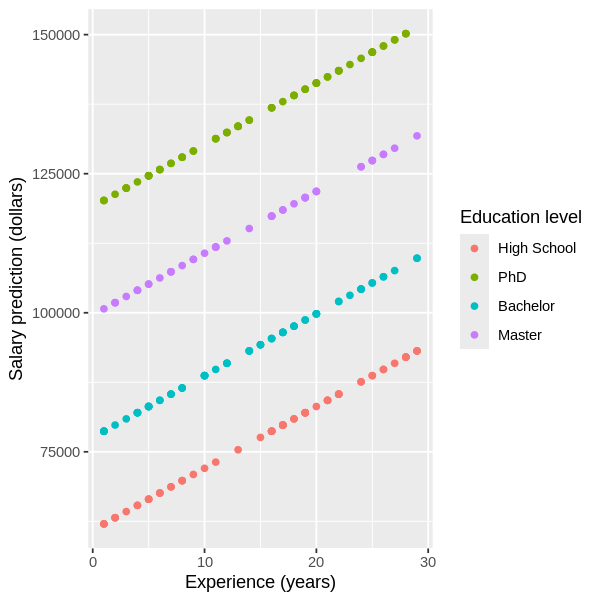

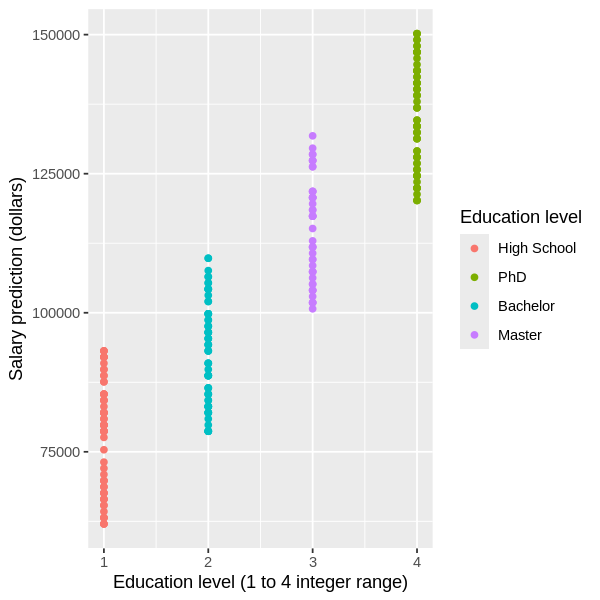

In [211]:
options(repr.plot.height = 5, repr.plot.width = 5)

exp_pred_plot <- ggplot(predictions, aes(x = experience_years, y = salary_pred, color = education)) +
    geom_point() +
    xlab("Experience (years)") +
    ylab("Salary prediction (dollars)") +
    labs(color="Education level")

edu_pred_plot <- ggplot(predictions, aes(x = education_level, y = salary_pred, color = education)) +
    geom_point() +
    xlab("Education level (1 to 4 integer range)") +
    ylab("Salary prediction (dollars)") +
    labs(color="Education level") +
    xlim(1, 4)    # We only have 4 levels of education so we restrict the plot to that area

#! Place plots side-by-side to take up less space
exp_pred_plot
edu_pred_plot

## Outcomes

## Impacts

## Future Questions

- low accuracy, because no relationship
- 

## Need to remove stuff below here.

## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

## Expected outcomes and significance

We expect to find that higher numbers in all predictor fields (salary, years of work experience, and age) predict a higher level of education.

We wish to use our findings to help someone determine what education level, years of experience, and age they should be in order to reach a certain salary range. These results may impact the way people choose to allocate the years of their life, and hopefully help them reach a decision in a less ambiguous way.

This analysis could lead to future questions about whether or not people should be spending their time and money on higher education in order to reach their desired financial position.